In [6]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


# MAKE COPY BEFORE SAVING

In [7]:
from matplotlib import pyplot
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np

# import pyarrow.parquet as pq
# import s3fs
from typing import List

from pathlib import Path

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# Functions

### Create Tarokka Deck

In [8]:
def create_tarokka_deck():
    tarokka_deck = pd.read_excel(
        "20200322_tarokka_deck_cos.xlsx",
    )
    tarokka_deck["book_suit"] = (
        tarokka_deck.loc[~tarokka_deck.suit.str.contains("high")]
        .suit.str.split("_")
        .apply(lambda x: x[1].title() + " of " + x[0].title() + "s")
    )
    cols = tarokka_deck.columns.tolist()
    cols = cols[0:2] + cols[-1:] + cols[2:-1]
    tarokka_deck = tarokka_deck.reindex(columns=cols)
    tarokka_deck = tarokka_deck.drop(columns=["suit"]).rename(
        columns={
            "book_suit": "suit",
            "clue": "treasure_clue",
            "location": "treasure_location",
        }
    )
    tarokka_deck.suit = tarokka_deck.suit.fillna("High")
    tarokka_deck = tarokka_deck.fillna("na")
    return tarokka_deck

In [9]:
# deck.loc[deck.suit.str.contains("high")]
#### Test code to see how often the while loop is triggered.
#### By my calculations it should happens ~23/1,000,000 of the time, but I'm not seeing that.
def draw_cards():
    tarokka_deck = create_tarokka_deck()
    common_deck = tarokka_deck.loc[~tarokka_deck.suit.str.contains("High")]
    high_deck = tarokka_deck.loc[tarokka_deck.suit.str.contains("High")]
    common_draws = common_deck[
        ["card_name", "suit", "treasure_clue", "treasure_location"]
    ].sample(3)

    high_draws = high_deck[
        [
            "card_name",
            "strahd_enemy_clue",
            "strahd_enemy",
            "strahd_location_clue",
            "strahd_location",
        ]
    ].sample(2)
    high_draw_check = high_draws.card_name.str.split("_").tolist()
    if high_draw_check[0][0] == high_draw_check[1][0]:
        while high_draw_check[0][0] == high_draw_check[1][0]:
            high_draws = high_deck[
                [
                    "card_name",
                    "strahd_enemy_clue",
                    "strahd_enemy",
                    "strahd_location_clue",
                    "strahd_location",
                ]
            ].sample(2)
            high_draw_check = high_draws.card_name.str.split("_").tolist()
    common_draws = common_draws.reset_index(drop=True)
    high_draws = high_draws.reset_index(drop=True)
    return common_draws, high_draws

In [10]:
# common_draws.iloc[[0]]
tarokka_deck = create_tarokka_deck()
tarokka_deck.head()

,card_name,suit,treasure_clue,treasure_location,strahd_enemy_clue,strahd_enemy,strahd_location_clue,strahd_location,Unnamed: 8,Unnamed: 9
0,artifact,High,na,na,Look for an entertaining man with a monkey. Th...,"This card refers to Rictavio (see appendix D),...",He lurks in the darkness where the morning lig...,Strahd faces the characters in the chapel (are...,na,na
1,beast,High,na,na,A werewolf holds a secret hatred for your enem...,This card refers to the werewolf Zuleika Toran...,The beast sits on his dark throne.,Strahd faces the characters in the audience ha...,na,na
2,broken_one_a,High,na,na,Your greatest ally will be a wizard. His mind ...,This card refers to the Mad Mage of Mount Bara...,He haunts the tomb of the man he envied above ...,Strahd faces the characters in Sergei’s tomb (...,na,na
3,broken_one_b,High,na,na,I see a man of faith whose sanity hangs by a t...,"This card refers to Donavich, the priest in th...",He haunts the tomb of the man he envied above ...,Strahd faces the characters in Sergei’s tomb (...,na,na
4,darklord,High,na,na,"Ah, the worst of all truths: You must face the...",There is no NPC who can inspire the characters.,"He lurks in the depths of darkness, in the one...",Strahd faces the characters in his tomb (area ...,na,na


In [11]:
tarokka_deck.loc[tarokka_deck.index == 40]

,card_name,suit,treasure_clue,treasure_location,strahd_enemy_clue,strahd_enemy,strahd_location_clue,strahd_location,Unnamed: 8,Unnamed: 9
40,miser,9 of Coins,"Look for a fortress inside a fortress, in a pl...",The treasure lies in Castle Ravenloft’s treasu...,na,na,na,na,na,na


In [12]:
tarokka_deck.loc[
    (tarokka_deck.suit == "High") & ~(tarokka_deck.card_name.str.endswith("_b"))
].shape

(14, 10)

The Tome of Strahd
This card tells of history. Knowledge of the ancient will help you better understand your enemy.

-3 of Coins -- Trader
Look to the wizard of wines! In wood and sand the treasure hides.

The Holy Symbol of Ravenkind
This card tells of of a powerful force for good and protection, a holy symbol of great hope.

-2 of Swords -- Paladin
I see a sleeping prince, a servant of light and the brother of darkness. The treasure lies with him.

The Sunsword
This is a card of power and strength. It tells of a weapon of vengeance: a sword of sunlight.

-6 of Coins -- Beggar
A wounded elf has what you seek. He will part with the treasure to see his dark dreams fulfilled.



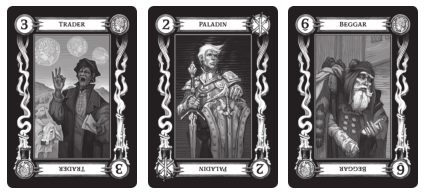

In [13]:
common_draws, high_draws = draw_cards()
file_path = Path().absolute()
common_card_name_search = common_draws.card_name.unique().tolist()
high_card_name_search = high_draws.card_name.unique().tolist()

common_card_name = common_draws.card_name.str.title().unique().tolist()
high_card_name = high_draws.card_name.str.title().unique().tolist()
high_card_name_first = high_card_name[0].split("_")[0]
high_card_name_second = high_card_name[1].split("_")[0]

suit = common_draws.suit.unique().tolist()
treasure_clue = common_draws.treasure_clue.unique().tolist()
treasure_location = common_draws.treasure_location.tolist()
strahd_enemy_clue = high_draws.strahd_enemy_clue.tolist()
strahd_enemy_clue_dm = high_draws.strahd_enemy.tolist()
strahd_location_clue = high_draws.strahd_location_clue.tolist()
strahd_location_clue_dm = high_draws.strahd_location.tolist()

ind = 0
fig, ax = pyplot.subplots(1, 3, squeeze=False)  # , sharex="col", sharey="row")
# pyplot.tight_layout()
gs1 = gridspec.GridSpec(1, 3)
gs1.update(wspace=0, hspace=0)
ax[0, 0].set_axis_off()
ax[0, 1].set_axis_off()
ax[0, 2].set_axis_off()
pyplot.rcParams["image.aspect"]
# ax[2, 2].set_axis_off()
data = pyplot.imread(f"{file_path}\\card_images\\{common_card_name_search[ind]}.png")

#         pyplot.rcParams["figure.figsize"] = [30, 15]
#         fig.suptitle("Treasure Cards\n", fontsize=40)
# pyplot.rcParams["image.aspect"]

ax[0, 0].imshow(data)
ax[0, 0].axis("off")
pyplot.tight_layout()
# pyplot.rcParams["image.aspect"]
treasure_clues_dm = {}
print(f"The Tome of Strahd")
print(
    f"This card tells of history. Knowledge of the ancient will help you better understand your enemy.\n"
)

print(f"-{suit[ind]} -- {common_card_name[ind]}")
print(f"{treasure_clue[ind]}\n")
treasure_clues_dm["Tome of Strahd"] = treasure_location[ind]

ind += 1
# fig, ax = plt.subplots(3, 3, squeeze=False)#, sharex="col", sharey="row")

data = pyplot.imread(f"{file_path}\\card_images\\{common_card_name_search[ind]}.png")

#         pyplot.rcParams["figure.figsize"] = [30, 15]

# pyplot.rcParams["image.aspect"]

ax[0, 1].imshow(data)
ax[0, 1].axis("off")

print(f"The Holy Symbol of Ravenkind")
print(
    f"This card tells of of a powerful force for good and protection, a holy symbol of great hope.\n"
)

print(f"-{suit[ind]} -- {common_card_name[ind]}")
print(f"{treasure_clue[ind]}\n")
treasure_clues_dm["Holy Symbol of Ravenkind"] = treasure_location[ind]

ind += 1

data = pyplot.imread(f"{file_path}\\card_images\\{common_card_name_search[ind]}.png")

#         pyplot.rcParams["figure.figsize"] = [30, 15]
#         fig.suptitle("Treasure Cards\n", fontsize=40)
# pyplot.rcParams["image.aspect"]

ax[0, 2].imshow(data)
# pyplot.rcParams["image.aspect"]
ax[0, 2].axis("off")

print(f"The Sunsword")
print(
    f"This is a card of power and strength. It tells of a weapon of vengeance: a sword of sunlight.\n"
)

print(f"-{suit[ind]} -- {common_card_name[ind]}")
print(f"{treasure_clue[ind]}\n")
treasure_clues_dm["Sunsword"] = treasure_location[ind]

-Strahd's Enemy
This card sheds light on one who will help you greatly in the battle against darkness.

--Raven
Find the leader of the feathered ones who live among the vines. Though old, he has one more fight left in him.

-Strahd
Your enemy is a creature of darkness, whose powers are beyond mortality. This card will lead you to him!

--Horseman
He lurks in the one place to which he must return — a place of death.



(-0.5, 599.5, 839.5, -0.5)

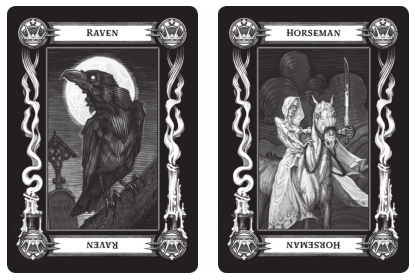

In [14]:
fig, ax = pyplot.subplots(1, 2, squeeze=False, sharex="col", sharey="row")

gs1 = gridspec.GridSpec(1, 3)
gs1.update(wspace=0, hspace=0)
ax[0, 0].set_axis_off()
ax[0, 1].set_axis_off()
pyplot.rcParams["image.aspect"]
strahd_clues_dm = {}
print(f"-Strahd's Enemy")
print(
    f"This card sheds light on one who will help you greatly in the battle against darkness.\n"
)
print(f"--{high_card_name_first}")
print(f"{strahd_enemy_clue[0]}\n")
strahd_clues_dm["Strahd's Enemy"] = strahd_enemy_clue_dm[0]
# fig, ax = plt.subplots(3, 3, squeeze=False)#, sharex="col", sharey="row")

data = pyplot.imread(f"{file_path}\\card_images\\{high_card_name_first}.png")

#         pyplot.rcParams["figure.figsize"] = [30, 15]
#         fig.suptitle("Treasure Cards\n", fontsize=40)
# pyplot.rcParams["image.aspect"]
ax[0, 0].imshow(data)
pyplot.tight_layout()
ax[0, 0].axis("off")

print(f"-Strahd")
print(
    f"Your enemy is a creature of darkness, whose powers are beyond mortality. This card will lead you to him!\n"
)
print(f"--{high_card_name_second}")
print(f"{strahd_location_clue[1]}\n")
# print(f"{strahd_location_clue_dm[1]}\n")
strahd_clues_dm["Strahd's Location"] = strahd_location_clue_dm[1]
# fig, ax = plt.subplots(3, 3, squeeze=False)#, sharex="col", sharey="row")

data = pyplot.imread(f"{file_path}\\card_images\\{high_card_name_second}.png")

#         pyplot.rcParams["figure.figsize"] = [30, 15]
#         fig.suptitle("Treasure Cards\n", fontsize=40)
ax[0, 1].imshow(data)
# pyplot.tight_layout()
ax[0, 1].axis("off")

In [15]:
## DM ONLY
for k, v in treasure_clues_dm.items():
    print(f"{k}\n")
    print(f"--{v}\n")

Tome of Strahd

--The treasure lies in the glassblower’s workshop in the Wizard of Wines winery (chapter 12, area W10).

Holy Symbol of Ravenkind

--The treasure lies in Sergei's tomb (chapter 4, area K85)

Sunsword

--The treasure is hidden in Kasimir’s hovel (chapter 5, area N9a).



In [16]:
## DM ONLY
for k, v in strahd_clues_dm.items():
    print(f"{k}\n")
    print(f"--{v}\n")

Strahd's Enemy

--This card refers to Davian Martikov (see chapter 12, “The Wizard of Wines”). The old wereraven, realizing that he has a chance to end Strahd’s tyranny, leaves his vineyard and winery in the capable hands of his sons, Adrian and Elvir. But before he travels to Castle Ravenloft to face Strahd, Davian insists on reconciling with his third son, Urwin Martikov (see chapter 5, area N2).

Strahd's Location

--Strahd faces the characters in his tomb (area K86).



# Test Code and Scraps

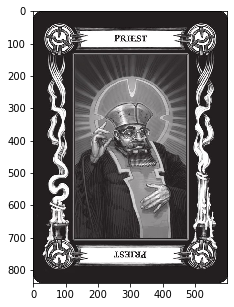

<IPython.core.display.Javascript object>

In [4]:
file_path = Path().absolute()
x = pyplot.imread(f"{file_path}\\card_images\\priest.png")
pyplot.rcParams["figure.figsize"] = [10, 5]
pyplot.imshow(x)

In [669]:
# deck.loc[deck.suit.str.contains("high")]
#### Test code to see how often the while loop is triggered.
#### By my calculations it should happen 18% of the time, but I'm not seeing that. 
tarokka_deck = create_tarokka_adeck()
common_deck = tarokka_deck.loc[~tarokka_deck.suit.str.contains("High")]
high_deck = tarokka_deck.loc[tarokka_deck.suit.str.contains("High")]
common_draws = common_deck[
    ["card_name", "suit", "treasure_clue", "treasure_location"]
].sample(3)

for_count = 0
for for_count in range(0, 1000000000):
    while_count = 0
    for_high_draws = high_deck[
        [
            "card_name",
            "strahd_enemy_clue",
            "strahd_enemy",
            "strahd_location_clue",
            "strahd_location",
        ]
    ].sample(2)
    high_draw_check = for_high_draws.card_name.str.split("_").tolist()
    if high_draw_check[0][0] == high_draw_check[1][0]:
#         print(high_draws.card_name)
        while (high_draw_check[0][0] == high_draw_check[1][0]):
#             print('for_high_draws:\n', for_high_draws.card_name)
            while_high_draws = high_deck[
                [
                    "card_name",
                    "strahd_enemy_clue",
                    "strahd_enemy",
                    "strahd_location_clue",
                    "strahd_location",
                ]
            ].sample(2)
            high_draw_check = while_high_draws.card_name.str.split("_").tolist()
#             print('while_high_draws:\n', while_high_draws.card_name)
            while_count += 1
            if while_count>=2:
#                 print('for_high_draws:\n', for_high_draws.card_name)
                print('while_high_draws:\n', while_high_draws.card_name)
                print('While count:', while_count)
                print('For count:', for_count)
    for_count += 1
#     print('While count:', while_count)
#     print('For count:', for_count)


while_high_draws:
 3     broken_one_b
17           mists
Name: card_name, dtype: object
while_high_draws:
 13    innocent_a
17         mists
Name: card_name, dtype: object
while_high_draws:
 2    broken_one_a
1           beast
Name: card_name, dtype: object
while_high_draws:
 14      innocent_b
3     broken_one_b
Name: card_name, dtype: object
while_high_draws:
 3    broken_one_b
0        artifact
Name: card_name, dtype: object
while_high_draws:
 2     broken_one_a
18           raven
Name: card_name, dtype: object
while_high_draws:
 7     executioner
2    broken_one_a
Name: card_name, dtype: object
while_high_draws:
 6      donjon_b
20    tempter_b
Name: card_name, dtype: object
while_high_draws:
 8          ghost_a
16    marionette_b
Name: card_name, dtype: object
while_high_draws:
 3     broken_one_b
11      horseman_a
Name: card_name, dtype: object
while_high_draws:
 16    marionette_b
8          ghost_a
Name: card_name, dtype: object
while_high_draws:
 13      innocent_a
2     brok

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

In [174]:
if high_draw_check
high_draws.head()
# card_list = deck.card_name.str.split("_").tolist()
# for card in card_list:
#     if card.count("a") > 0 or card.count("b") > 0:
#         print(card)
#     else:
#         pass

,card_name,strahd_enemy_clue,strahd_enemy,strahd_location_clue,strahd_location
5,donjon_a,Search for a troubled young man surrounded by ...,This card refers to Victor Vallakovich (see ch...,"He lurks in a hall of bones, in the dark pits ...",Strahd faces the characters in the hall of bon...
7,executioner,Seek out the brother of the devil’s bride. The...,This card refers to Ismark Kolyanovich (see ch...,"I see a dark figure on a balcony, looking down...",Strahd faces the characters at the overlook (a...


<IPython.core.display.Javascript object>

### Draw Cards

In [35]:
def draw_cards():
    tarokka_deck = create_tarokka_deck()
    common_deck = tarokka_deck.loc[~tarokka_deck.suit.str.contains("High")]
    high_deck = tarokka_deck.loc[tarokka_deck.suit.str.contains("High")]
    
    common_draws = common_deck[['card_name', 'suit', 'treasure_clue', 'treasure_location']].sample(3)
    high_draws = high_deck[['card_name','strahd_enemy_clue','strahd_enemy','strahd_location_clue','strahd_location']].sample(2)
    
    common_draw_list = []
    for common_cards in common_draws.iterrows():
        common_card_draw_list.append((common_cards[1][1], common_cards[1][0]))

    common_card_draw_list

    high_card_draw_list = (
        tarokka_deck.loc[tarokka_deck.suit.str.contains("high")]
        .sample(2)
        .card_name.unique()
        .tolist()
    )
    return common_card_draw_list, high_card_draw_list

In [36]:
[common_draws, high_draws] = draw_cards()
### Draw 3 Cards from common deck
# print(f"Common Draws: \n{common_card_names}\n")
print(f"Common Draws: \n{common_draws}\n")

### Draw 2 cards from the high deck
print(f"High Draws: \n{high_draws}\n")

Common Draws: 
[('glyph_master', 'priest'), ('glyph_2', 'missionary'), ('star_4', 'abjurer')]

High Draws: 
['seer', 'beast']



### Readouts

In [30]:
print(f"The Tome of Strahd")
print(
    f"This card tells of history. Knowledge of the ancient will help you better understand your enemy.\n{common_draws[0]}\n"
)

print(f"The Holy Symbol of Ravenkind")
print(
    f"This card tells of of a powerful force for good and protection, a holy symbol of great hope.\n{common_draws[1]}\n"
)

print(f"The Sunsword")
print(
    f"This is a card of power and strength. It tells of a weapon of vengeance: a sword of sunlight.\n{common_draws[2]}\n"
)

print(f"Strahd's Enemy")
print(
    f"This card sheds light on one who will help you greatly in the battle against darkness.\n{high_draws[0]}\n"
)

print(f"Strahd")
print(
    f"Your enemy is a creature of darkness, whose powers are beyond mortality. This card will lead you to him!\n{high_draws[1]}\n"
)

The Tome of Strahd
This card tells of history. Knowledge of the ancient will help you better understand your enemy.
('sword_8', 'dictator')

The Holy Symbol of Ravenkind
This card tells of of a powerful force for good and protection, a holy symbol of great hope.
('glyph_6', 'anarchist')

The Sunsword
This is a card of power and strength. It tells of a weapon of vengeance: a sword of sunlight.
('glyph_1', 'monk')

Strahd's Enemy
This card sheds light on one who will help you greatly in the battle against darkness.
horseman

Strahd
Your enemy is a creature of darkness, whose powers are beyond mortality. This card will lead you to him!
executioner



<IPython.core.display.Javascript object>